In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [41]:
df = pd.read_csv('../data/bm2019_pm_data.csv', index_col='datetime', parse_dates=True)

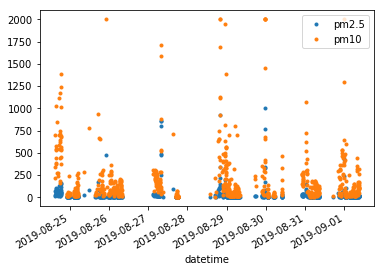

In [42]:
df[['pm2.5', 'pm10']].plot(style='.')

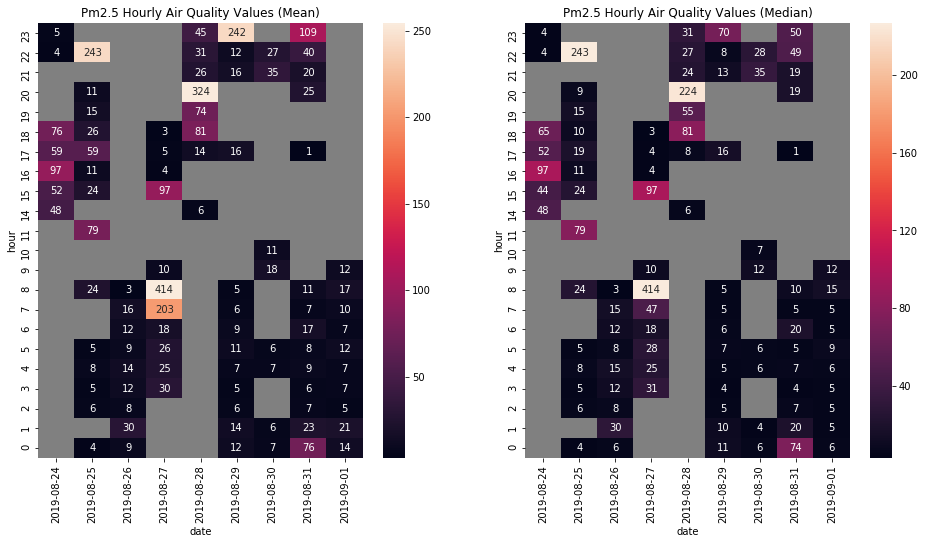

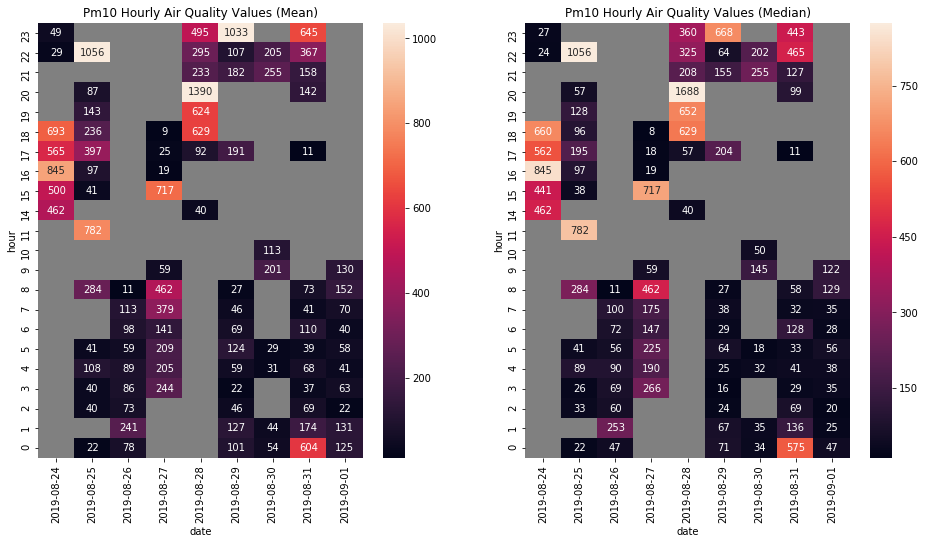

In [92]:

def get_heatmap_df(var, avg_type='mean'):
    df_heatmap = df[var].groupby([df.index.date, df.index.hour])
    if avg_type == 'mean':
        df_heatmap = df_heatmap.mean()
    elif avg_type == 'median':
        df_heatmap = df_heatmap.median()
    df_heatmap = df_heatmap.reset_index()
    df_heatmap.columns = ['date', 'hour', var]
    df_heatmap_pivoted = df_heatmap.pivot(
        index='hour', columns='date', values=var).sort_index(ascending=False
    ).round()
    return df_heatmap_pivoted

for var in ['pm2.5', 'pm10']:
    f, axes = plt.subplots(1, 2, figsize=(16, 8))
    for i, avg_type in enumerate(['mean', 'median']):
        cmap = sns.cm.rocket
        cmap = cmap.set_bad("grey") 
        axes[i].title.set_text('{} Hourly Air Quality Values ({})'.format(var, avg_type).title())
        sns.heatmap(get_heatmap_df(var, avg_type), annot=True, cmap=cmap, robust=True, fmt='g', ax=axes[i])